In [17]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np
import torch
import torch.optim as optim
import pandas as pd
from abn.models.spherical_vae import SphericalVAE
from abn.trainer.svae_trainer import SphericalVAETrainer
from abn.datasets.cyclic_walk import CyclicWalk
from abn.new_vae.datasets.wiggles import Wiggles
from abn.datasets.data_loader import TrainValLoader

INFO: Using pytorch backend


# Hyperspherical VAE

## Load Dataset

40it [00:41,  1.03s/it]
/Users/sophia/projects/abn/abn/notebooks/../../abn/datasets/cyclic_walk.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(angles, dtype=torch.float32)


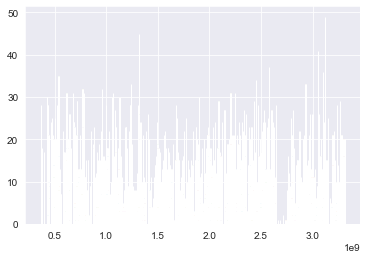

In [19]:
path = "../data/expt34.mat" # CHANGE TO YOUR DATA LOCATION IF NEEDED
time_bin = 1000000
dataset = CyclicWalk(path=path, time_bin=time_bin, velocity_threshold=0.3)

In [10]:
# torch.save(dataset, "../data/expt34_processed.pt")

In [23]:
dataset = torch.load("../data/expt34_processed.pt")

In [39]:
dataset = Wiggles(n_times=1000,n_wiggles=5, synth_radius=1,amp_wiggles=0.3,embedding_dim=2,rotation=True,noise_var=0.001)

## Normalize the Data

Note: Different normalization schemes have a *HUGE* impact on the training procedure.
Options that should be explored include:
- Z-scoring each neuron's response across the entire dataset
- Setting min of the entire dataset to 0 and max to 1
- Setting the norm of each neural state vector to 1

They are each implemented below. Uncomment options to try them out

In [66]:
"""
Z-Scoring
"""
# dataset.data = dataset.data - dataset.data.mean(axis=-1, keepdim=True)
# dataset.data = dataset.data / dataset.data.std(axis=-1, keepdim=True)
# print(dataset.data.std(axis=-1))

'\nZ-Scoring\n'

In [40]:
"""
Min 0 Max 1
"""
dataset.data = dataset.data - dataset.data.min()
dataset.data = dataset.data / dataset.data.max()

In [21]:
"""
Unit Norm
"""
# dataset.data = dataset.data / torch.linalg.norm(dataset.data, dim=-1, keepdim=True)
# print(torch.linalg.norm(dataset.data, dim=-1))

'\nUnit Norm\n'

## Train Val Split and Generate Batches

In [42]:
data_loader = TrainValLoader(batch_size=20)
data_loader.load(dataset)

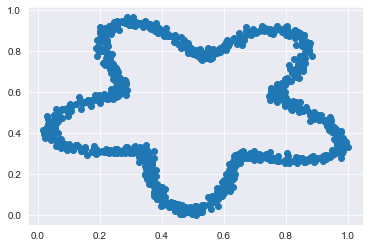

In [41]:
x=dataset.data[:,0]
y = dataset.data[:,1]
plt.scatter(x,y)

## Construct Model

In [43]:
model = SphericalVAE(input_dim=2,
                     encoder_dims=[40, 100, 50, 10],
                     latent_dim=2,
                     distribution="vmf")

optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = SphericalVAETrainer(model=model, optimizer=optimizer)

## Train Model

In [44]:
trainer.train(data_loader, 200)

/Users/franciscoacosta/opt/anaconda3/envs/abn1/lib/python3.9/site-packages/torch/distributions/distribution.py:44: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


Epoch 0 ||  N Examples 0 || Train Total Loss 1.39171 || Validation Total Loss 1.37618
Epoch 1 ||  N Examples 800 || Train Total Loss 1.35979 || Validation Total Loss 1.39164
Epoch 2 ||  N Examples 1600 || Train Total Loss 1.35772 || Validation Total Loss 1.35026
Epoch 3 ||  N Examples 2400 || Train Total Loss 1.35071 || Validation Total Loss 1.35597
Epoch 4 ||  N Examples 3200 || Train Total Loss 1.34997 || Validation Total Loss 1.35610
Epoch 5 ||  N Examples 4000 || Train Total Loss 1.34201 || Validation Total Loss 1.36068
Epoch 6 ||  N Examples 4800 || Train Total Loss 1.35089 || Validation Total Loss 1.35317
Epoch 7 ||  N Examples 5600 || Train Total Loss 1.34405 || Validation Total Loss 1.34726
Epoch 8 ||  N Examples 6400 || Train Total Loss 1.33005 || Validation Total Loss 1.33349
Epoch 9 ||  N Examples 7200 || Train Total Loss 1.32801 || Validation Total Loss 1.35970
Epoch 10 ||  N Examples 8000 || Train Total Loss 1.33145 || Validation Total Loss 1.33491
Epoch 11 ||  N Examples 

## Visualize Latent Space

In [45]:
with torch.no_grad():
    (z_mean, z_var), (q_z, p_z), z = model.to_latent(dataset.data)

In [46]:
df = pd.DataFrame({"z0": z[:, 0], 
                    "z1": z[:, 1], 
                    "pos": dataset.labels % (2 * np.pi)})
#                     "pos": (dataset.pos + dataset.angle) % (2 * np.pi)})

<AxesSubplot:xlabel='z0', ylabel='z1'>

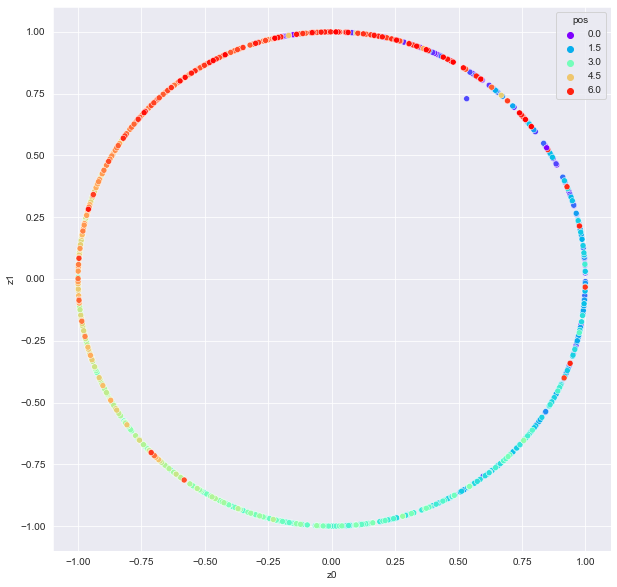

In [47]:
plt.figure(figsize=(10, 10))
sns.scatterplot(x="z0", y="z1", hue="pos", data=df, palette="rainbow")

Text(0.5, 1.0, 'hello')

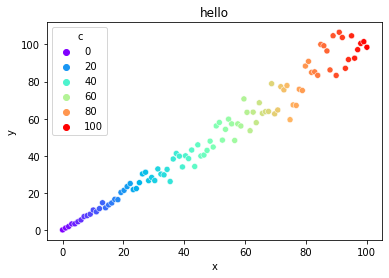

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig = plt.figure()

x = np.linspace(0,100,100)

y = np.random.normal(x,x/10)

df = pd.DataFrame({     
    "x":x,
    "y":y,
    "c":x
    })

sc = sns.scatterplot(x = "x", y="y", hue="c", data=df, palette="rainbow")
plt.title("hello")


In [48]:
def get_immersion(model):

    def immersion(angle):
        z = torch.tensor([torch.cos(angle), torch.sin(angle)])
        x_rec = model.decode(z)
        return x_rec

    return immersion

In [49]:
def plot_model(thetas, model):
    immersion = get_immersion(model)
    z = [immersion(theta) for theta in thetas]
    x = [vec[0].detach().numpy() for vec in z]
    y = [vec[1].detach().numpy() for vec in z]
    plt.scatter(x,y,c=thetas)

In [50]:
angles = torch.linspace(0,2*torch.pi,1000)

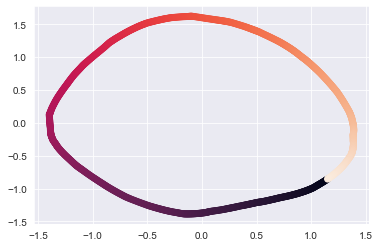

In [51]:
plot_model(angles, model)

In [52]:
model

SphericalVAE(
  (encoder): Sequential(
    (fullyconnected_0): Linear(in_features=2, out_features=40, bias=True)
    (activation_0): LeakyReLU(negative_slope=0.1)
    (fullyconnected_1): Linear(in_features=40, out_features=100, bias=True)
    (activation_1): LeakyReLU(negative_slope=0.1)
    (fullyconnected_2): Linear(in_features=100, out_features=50, bias=True)
    (activation_2): LeakyReLU(negative_slope=0.1)
    (fullyconnected_3): Linear(in_features=50, out_features=10, bias=True)
    (out_3): ReLU()
  )
  (mu): Linear(in_features=10, out_features=2, bias=True)
  (var): Linear(in_features=10, out_features=1, bias=True)
  (decoder): Sequential(
    (fullyconnected_0): Linear(in_features=2, out_features=10, bias=True)
    (activation_0): LeakyReLU(negative_slope=0.1)
    (fullyconnected_1): Linear(in_features=10, out_features=50, bias=True)
    (activation_1): LeakyReLU(negative_slope=0.1)
    (fullyconnected_2): Linear(in_features=50, out_features=100, bias=True)
    (activation_2):

In [53]:
def mean_curv(base_point, immersion, embedding_dim):
    H = torch.zeros(embedding_dim)
    for i in range(embedding_dim):
        H[i] = torch.autograd.functional.hessian(
            func=lambda x: immersion(x)[i], inputs=base_point
        )
    return H

In [54]:
def get_curv_profile(angles,model,embedding_dim):
    immersion = get_immersion(model)
    mean_curv_vecs = [mean_curv(angle,immersion,embedding_dim) for angle in angles]
    norms = [torch.linalg.norm(vec) for vec in mean_curv_vecs]
    return norms

In [56]:
angles = torch.linspace(0,2*torch.pi,1000)

norms = get_curv_profile(angles,model,2)

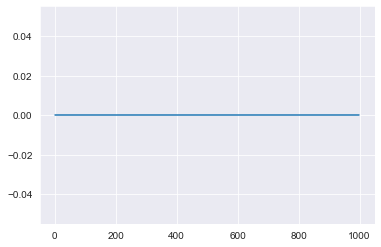

In [57]:
plt.plot(norms)